# Installation

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, optimizers
from functools import reduce
from operator import mul

# Dataset

## Loading [train_ds, ds_info]

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


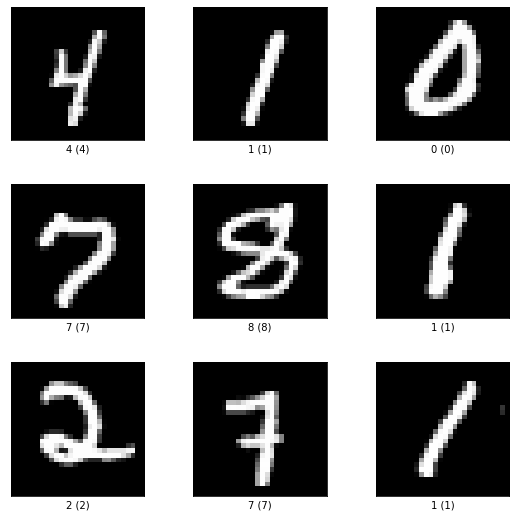

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

In [ ]:
train_ds, ds_info = tfds.load('mnist', split='train', with_info=True)
tfds.show_examples(train_ds, ds_info)
ds_info

## Preprocessing [train_prep_ds]

In [ ]:
from functools import reduce

def dsitem_to_tuple(item):
  return (item['image'], item['label'])

def normalize_image(image, label):
  return tf.cast(image, tf.float32)/255, label

def onehot_encode(xvalue, label):
  return xvalue, tf.one_hot(tf.cast(label, tf.uint8), ds_info.features['label'].num_classes)

def prepfn(ds, funcs = [dsitem_to_tuple]):
  return reduce(lambda y,x: y.map(x), funcs, ds)

train_prep_ds = prepfn(train_ds)
#test_prep_ds = prepfn(test_ds)

#test_prep_ds.as_numpy_iterator().next()
#tfds.show_examples(train_ds, ds_info)

# Visualization

In [ ]:
def plot(ds, count=4):
  ds_itr = ds.as_numpy_iterator()
  plt.figure(figsize=(20, 20))

  for itemid in range(min(count, len(ds))):
    image, label = ds_itr.next()

    ax = plt.subplot(3, 4, itemid + 1)
    #ax.set_title(labels_to_string(label))
    #print(labels_to_string(label))
    plt.imshow(image, cmap='gray')

    plt.axis("off")

# Functions (is_labelfn)

In [ ]:
def islabelfn(label):
  return lambda x,y: True if y == label else False

def pos_labelfn(image, label):
  return image, 1

def neg_labelfn(image, label):
  return image, 0

def squeeze_channel(image, label):
  return tf.squeeze(image, axis=2), label

def noisefn(id):
  noise = tf.random.uniform((100,))
  return noise, 0

def modelfn(m, input):
  input = tf.expand_dims(input, axis=0)
  output = m(input, training=False)
  squeezed = tf.squeeze(output, axis=0)
  return squeezed

def gan_mnist_discriminator(INP_SHAPE=(28,28,1)):
  model = keras.Sequential([
    layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=INP_SHAPE, activation='relu'),
    layers.Dropout(0.4),
    layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', activation='relu'),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
  ])

  optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  
  return model

def gan_mnist_generator(IMG_SIZE=7, NOISE_SIZE=100):
  layer_1_size = 128 * IMG_SIZE * IMG_SIZE
  model = keras.Sequential([
    layers.Dense(layer_1_size, input_dim=NOISE_SIZE, activation='relu'),
    layers.Reshape((IMG_SIZE, IMG_SIZE, 128)),
    layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu'),
    layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu'),
    layers.Conv2D(1, (7, 7), activation='sigmoid', padding='same')
  ])

  return model

def gan(generator, discriminator):
  discriminator.trainable = False
  model = keras.Sequential([generator, discriminator])
  optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

def train_gan(g, d, model, real_ds, noise_ds, BATCH_SIZE=2048, EPOCHS=100):
  for epoch_id in range(EPOCHS):
    # Create datasets
    syn_ds = noise_ds.map(lambda x,y: (modelfn(g, x), y)) # Synthetic samples
    pos_noise_ds = noise_ds.map(lambda x,y: (x, 1))

    # Create batches
    real_batch_ds = real_ds.shuffle(1000).batch(BATCH_SIZE)
    syn_batch_ds = syn_ds.shuffle(1000).batch(BATCH_SIZE)
    pos_noise_batch_ds = pos_noise_ds.shuffle(1000).batch(BATCH_SIZE)
    
    # Create iterators
    real_batch_itr = iter(real_batch_ds)
    syn_batch_itr = iter(syn_batch_ds)
    pos_noise_batch_itr = iter(pos_noise_batch_ds)

    for batch_id in range(len(real_batch_ds)):
      # Train Discriminator
      X_real, Y_real = real_batch_itr.next()
      X_syn, Y_false = syn_batch_itr.next()
      X_mix = tf.concat([X_real, X_syn], 0)
      Y_mix = tf.concat([Y_real, Y_false], 0)
      d.trainable = True # Enable discriminator training
      d_loss, _ = d.train_on_batch(X_mix, Y_mix)

      # Train GAN
      X_noise, Y_true = pos_noise_batch_itr.next()
      d.trainable = False # Disable discriminator training
      gan_loss, _ = model.train_on_batch(X_noise, Y_true)

    print('Training status: epoch: %d, d_loss: %.5f, g_loss: %.5f' % (epoch_id, d_loss, gan_loss))

# Generator, Discriminator and the GAN
d = gan_mnist_discriminator()
g = gan_mnist_generator()

# Prepare Dataset for GAN
real_ds = prepfn(train_ds, [dsitem_to_tuple, normalize_image, pos_labelfn]).cache()
noise_ds = tf.data.Dataset.from_tensor_slices(range(len(real_ds))).cache().map(noisefn)

model = gan(g, d)
#model.summary()
#d.summary()
#g.summary()
#g.summary()
#g.predict(noise_X)

#train_gan(g, d, model, real_ds, noise_ds, EPOCHS=20)
#print(real_ds.as_numpy_iterator().next(), noise_ds.as_numpy_iterator().next())
#print(noise_ds.as_numpy_iterator().next())
#print(mix_ds.as_numpy_iterator().next())

Epoch: 0 d_loss: 0.04097 gan_loss: 3.68935
Epoch: 1 d_loss: 0.44185 gan_loss: 0.94942
Epoch: 2 d_loss: 0.48313 gan_loss: 1.48685
Epoch: 3 d_loss: 0.54843 gan_loss: 0.71721
Epoch: 4 d_loss: 0.64107 gan_loss: 0.97619
Epoch: 5 d_loss: 0.76875 gan_loss: 0.69751
Epoch: 6 d_loss: 0.70110 gan_loss: 0.66386
Epoch: 7 d_loss: 0.67020 gan_loss: 0.70913
Epoch: 8 d_loss: 0.67562 gan_loss: 0.69514
Epoch: 9 d_loss: 0.71572 gan_loss: 0.69262
Epoch: 10 d_loss: 0.74424 gan_loss: 0.65896
Epoch: 11 d_loss: 0.72065 gan_loss: 0.76643
Epoch: 12 d_loss: 0.65987 gan_loss: 0.83240
Epoch: 13 d_loss: 0.59001 gan_loss: 0.78431
Epoch: 14 d_loss: 0.55371 gan_loss: 0.85299
Epoch: 15 d_loss: 0.83484 gan_loss: 0.80928
Epoch: 16 d_loss: 0.59487 gan_loss: 0.88520
Epoch: 17 d_loss: 0.64136 gan_loss: 0.76594
Epoch: 18 d_loss: 0.68828 gan_loss: 0.75317
Epoch: 19 d_loss: 0.77362 gan_loss: 0.69096


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 20 d_loss: 0.57496 gan_loss: 0.95462
Epoch: 21 d_loss: 0.59743 gan_loss: 0.89439
Epoch: 22 d_loss: 0.57423 gan_loss: 0.91126
Epoch: 23 d_loss: 0.66915 gan_loss: 0.74818
Epoch: 24 d_loss: 0.52811 gan_loss: 1.00476
Epoch: 25 d_loss: 0.62983 gan_loss: 0.72481
Epoch: 26 d_loss: 0.74068 gan_loss: 0.85091
Epoch: 27 d_loss: 0.83122 gan_loss: 0.87819
Epoch: 28 d_loss: 0.52452 gan_loss: 1.03021
Epoch: 29 d_loss: 0.68049 gan_loss: 0.99495
Epoch: 30 d_loss: 0.46735 gan_loss: 1.07963
Epoch: 31 d_loss: 0.67413 gan_loss: 0.95176
Epoch: 32 d_loss: 0.59992 gan_loss: 0.87540
Epoch: 33 d_loss: 0.70069 gan_loss: 0.72906
Epoch: 34 d_loss: 0.76444 gan_loss: 0.77949
Epoch: 35 d_loss: 0.67869 gan_loss: 0.86909
Epoch: 36 d_loss: 0.73156 gan_loss: 0.89293
Epoch: 37 d_loss: 0.45087 gan_loss: 1.18536
Epoch: 38 d_loss: 0.57108 gan_loss: 0.94269
Epoch: 39 d_loss: 0.49305 gan_loss: 1.23027
Epoch: 40 d_loss: 0.67470 gan_loss: 1.09727
Epoch: 41 d_loss: 0.48100 gan_loss: 1.55110
Epoch: 42 d_loss: 0.45780 gan_lo

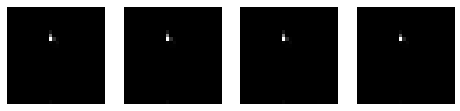

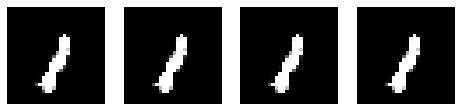

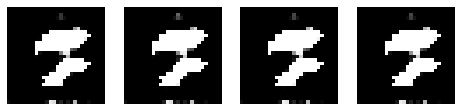

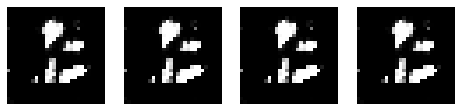

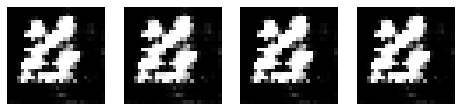

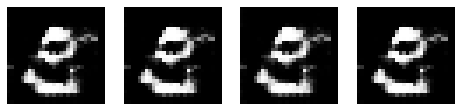

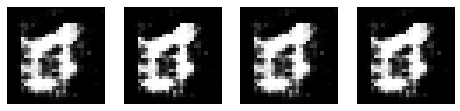

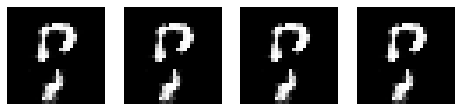

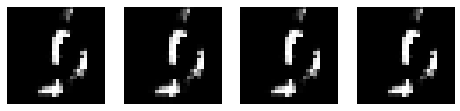

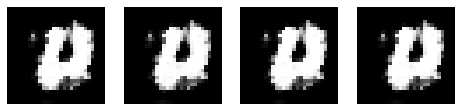

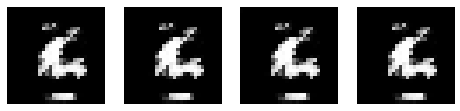

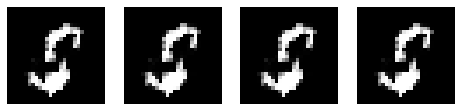

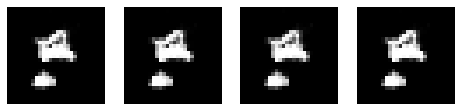

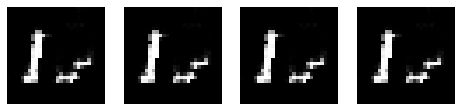

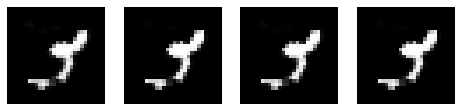

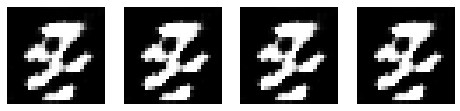

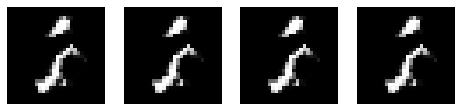

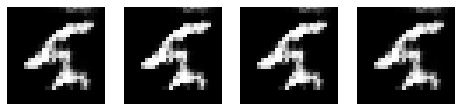

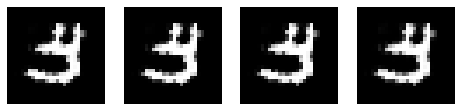

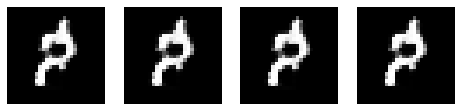

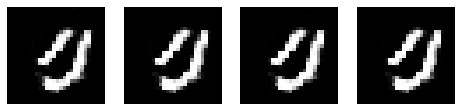

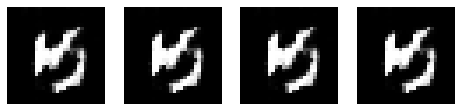

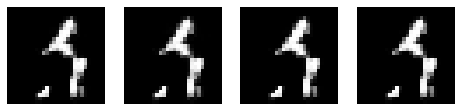

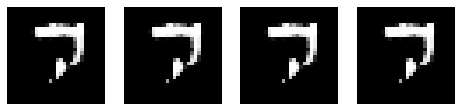

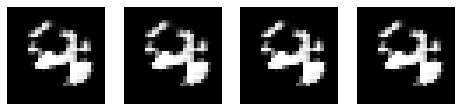

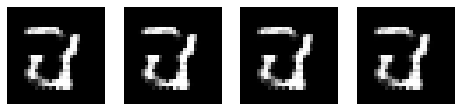

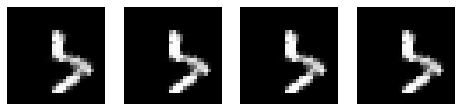

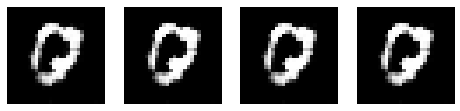

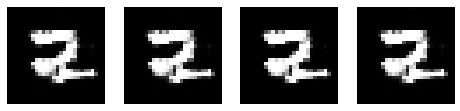

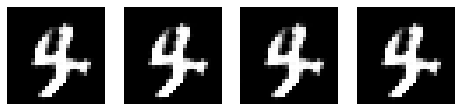

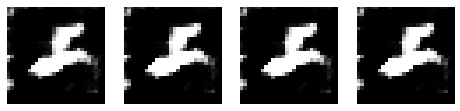

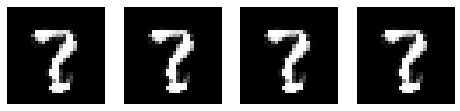

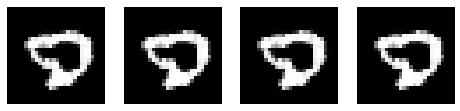

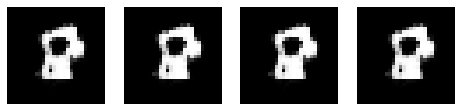

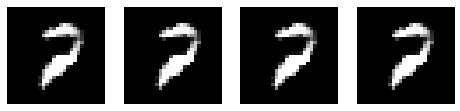

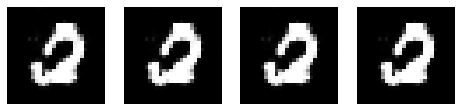

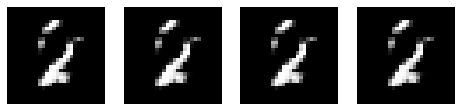

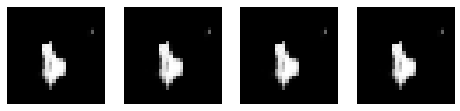

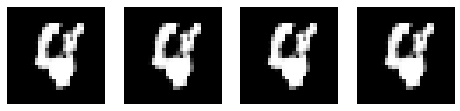

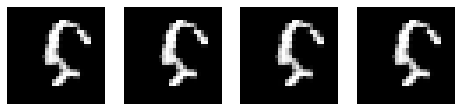

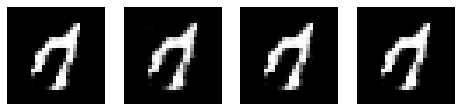

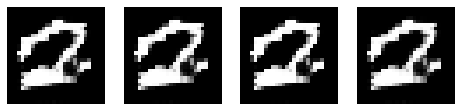

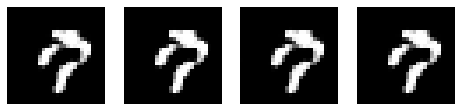

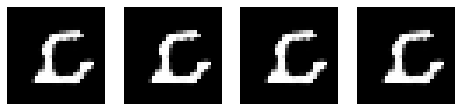

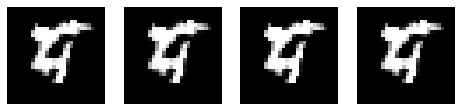

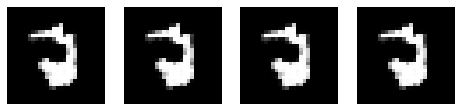

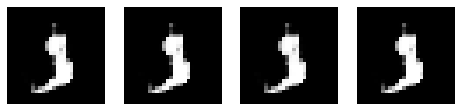

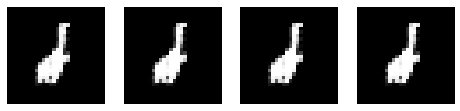

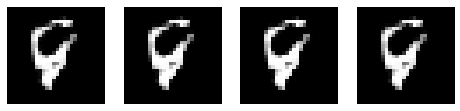

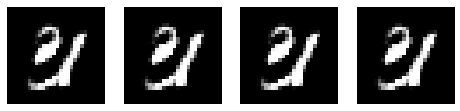

In [ ]:
def train_on_batch(m, X, Y):
  loss, _ = m.train_on_batch(X, Y)

  return loss

def train_gan(g, d, model, real_ds, BATCH_SIZE=32, EPOCHS=10):
  DS_LEN = len(real_ds)
  NOISE = tf.random.uniform((EPOCHS, DS_LEN, 100,))

  d_loss, model_loss = None, None

  for epoch_id in range(EPOCHS):
    # Create datasets
    pos_noise_ds = tf.data.Dataset.from_tensor_slices(NOISE[epoch_id]).map(lambda x: (x, 1))

    # Create batches
    real_batch_ds = real_ds.shuffle(DS_LEN, reshuffle_each_iteration=True).batch(BATCH_SIZE)
    pos_noise_batch_ds = pos_noise_ds.shuffle(DS_LEN, reshuffle_each_iteration=True).batch(BATCH_SIZE)

    for ((X_real, Y_real), (X_pos_noise, Y_pos_noise)) in zip(real_batch_ds, pos_noise_batch_ds):
      X_mix = tf.concat([X_real, g(X_pos_noise, training=False)], 0)
      Y_mix = tf.concat([Y_real, tf.zeros(Y_pos_noise.shape, tf.int32)], 0)

      d.trainable = True
      d_loss = train_on_batch(d, X_mix, Y_mix)

      d.trainable = False
      model_loss = train_on_batch(model, X_pos_noise, Y_pos_noise)
    
    plot(pos_noise_ds.map(lambda x, y: (modelfn(g, x), y)).map(squeeze_channel))
    
    print('Epoch: %d d_loss: %.5f gan_loss: %.5f' % (epoch_id, d_loss, model_loss))

d = gan_mnist_discriminator()
g = gan_mnist_generator()

# Prepare Dataset for GAN
slice_ds = train_ds.shuffle(1000, reshuffle_each_iteration=True).take(10000)
real_ds = prepfn(slice_ds, [dsitem_to_tuple, normalize_image, pos_labelfn]).cache()

model = gan(g, d)
train_gan(g, d, model, real_ds, EPOCHS=50)

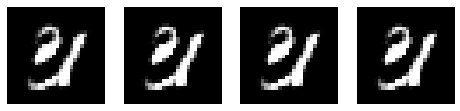

In [ ]:
NOISE = tf.random.uniform((10, 10, 100,))
pos_noise_ds = tf.data.Dataset.from_tensor_slices(NOISE[9]).map(lambda x: (x, 1))
plot(pos_noise_ds.map(lambda x, y: (modelfn(g, x), y)).map(squeeze_channel))

Epoch: 0 d_loss: 0.42902 gan_loss: 1.18529
Epoch: 1 d_loss: 0.35419 gan_loss: 1.26599
Epoch: 2 d_loss: 0.35030 gan_loss: 1.45528
Epoch: 3 d_loss: 0.38148 gan_loss: 1.37177
Epoch: 4 d_loss: 0.50152 gan_loss: 0.93129


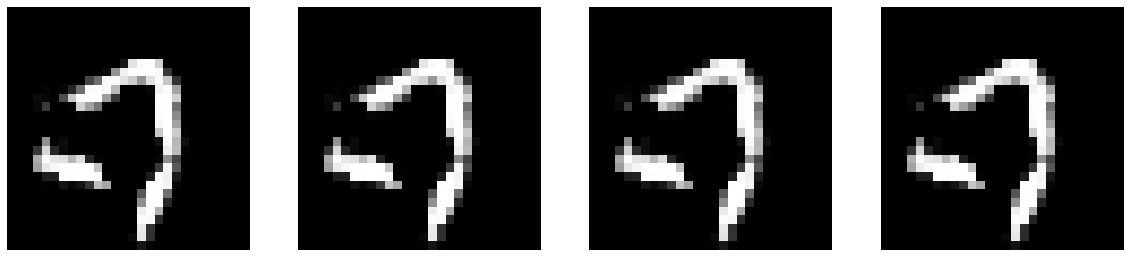

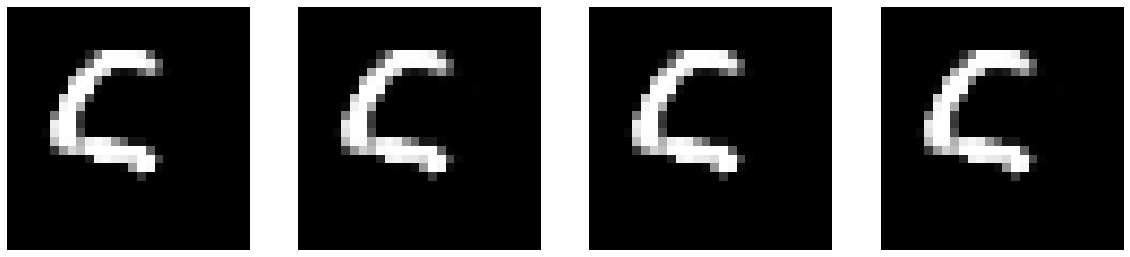

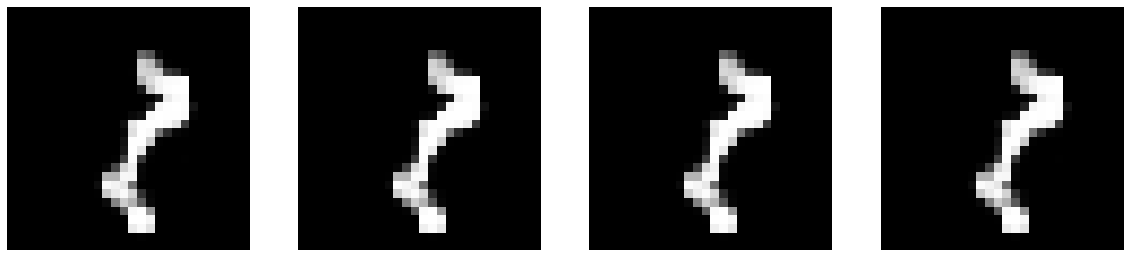

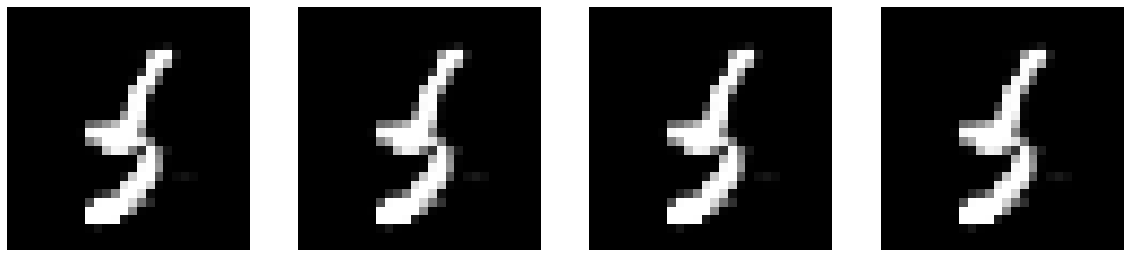

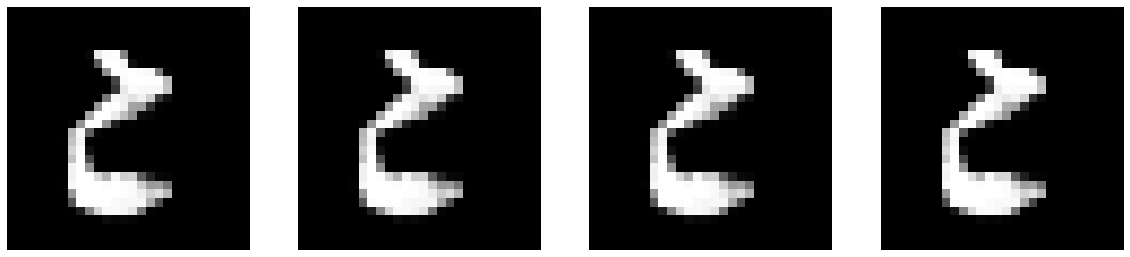

In [ ]:
train_gan(g, d, model, real_ds, EPOCHS=5)

In [ ]:
model.save_weights('initial_weights.h5')

In [ ]:
from google.colab import files
files.download('initial_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# SMOTE

In [ ]:
train_0_ds = train_prep_ds.filter(islabelfn(0))
itr = train_0_ds.as_numpy_iterator()
candidate, _ = itr.next()
itr.next()
neighbor, _ = itr.next()
#tfds.show_examples(train_0_ds, ds_info)

In [ ]:
diff = candidate - neighbor.astype(int)
mid_point = diff / 2
synthetic = neighbor + mid_point
print(synthetic.astype(int))

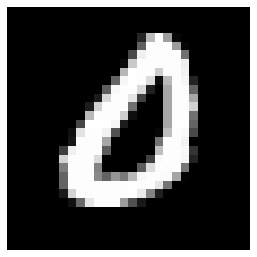

<Figure size 432x288 with 0 Axes>

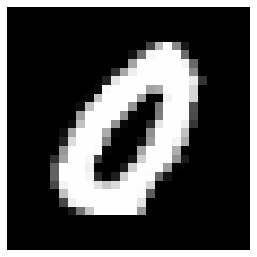

<Figure size 432x288 with 0 Axes>

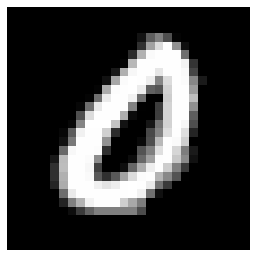

In [ ]:

candidate_ds = tf.data.Dataset.from_tensor_slices(([candidate], [0])).map(squeeze_channel)
neighbor_ds = tf.data.Dataset.from_tensor_slices(([neighbor], [0])).map(squeeze_channel)
smote_ds = tf.data.Dataset.from_tensor_slices(([synthetic], [0])).map(squeeze_channel)

plot(candidate_ds)

plt.figure()
plot(neighbor_ds)

plt.figure()
plot(smote_ds)